In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from collections import Counter

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def conf_matrix(y, y_pred, title, labels):
  sns.set(font_scale=1.5)
  fig, ax =plt.subplots(figsize=(7.5,7.5))
  ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="YlGnBu", fmt='g', cbar=False, annot_kws={"size":30})
  plt.title(title, fontsize=20)
  ax.xaxis.set_ticklabels(labels, fontsize=10)
  ax.yaxis.set_ticklabels(labels, fontsize=10)
  ax.set_ylabel('True label', fontsize=20)
  ax.set_xlabel('Predicted', fontsize=20)
  plt.show()

In [ ]:
data_path = '/content/drive/My Drive/CS505 Datasets/final/'
df = pd.read_csv(data_path + 'cleaned_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38729 entries, 0 to 38728
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          38729 non-null  object
 1   labels        38729 non-null  object
 2   cleaned_text  38729 non-null  object
 3   text_len      38729 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
seed_value = 42

In [ ]:
labels2idx = {k: i for i, k in enumerate(df['labels'].unique())}
idx2labels = {k: labels2idx[k] for k in labels2idx.keys()}

In [ ]:
# train-validation-test split
X = df['cleaned_text']
y = [labels2idx[i] for i in df['labels']]
TRAIN_SIZE = 0.7
VALID_SIZE = 0.15
total_size = len(X)
train_size = int(TRAIN_SIZE * total_size)
valid_size = int(VALID_SIZE * total_size)
test_size = total_size - train_size - valid_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(train_size+valid_size), test_size=test_size, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=train_size, test_size=valid_size, stratify=y_train, random_state=seed_value)

In [ ]:
# baseline model: Naive Bayes

vectorizer = CountVectorizer()
X_train_cv =  vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

# use TF-IDF to calculate the weight of each word based on its frequency
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tf, y_train)

nb_pred = nb_model.predict(X_test_tf)

In [ ]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=idx2labels.keys()))

Classification Report for Naive Bayes:
                    precision    recall  f1-score   support

not_cyberbullying       0.87      0.44      0.58      1132
           gender       0.89      0.84      0.86      1141
         religion       0.82      0.97      0.89      1191
              age       0.76      0.98      0.86      1182
        ethnicity       0.88      0.92      0.90      1164

         accuracy                           0.83      5810
        macro avg       0.84      0.83      0.82      5810
     weighted avg       0.84      0.83      0.82      5810



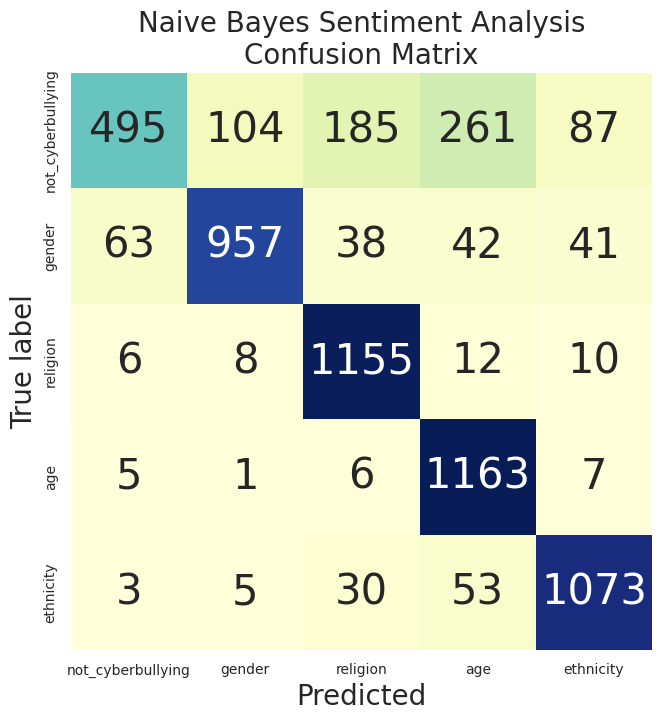

In [ ]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', idx2labels.keys())

In [ ]:
def load_glove_model(file):
  print("Loading Glove Model")
  glove_model = {}
  with open(file, 'r') as f:
    for line in f:
      split_line = line.split()
      word = split_line[0]
      embedding = np.array(split_line[1:], dtype=np.float32)
      glove_model[word] = embedding
  print(f"{len(glove_model)} words loaded!")
  return glove_model

embedding_file = data_path+'glove.6B.200d.txt'
embedding_dim = 200
glove_model = load_glove_model(embedding_file)

Loading Glove Model
400000 words loaded!


In [ ]:
# creat a dictionary for all the words in the training set
all_words = ' '.join(df['cleaned_text']).split()
word2idx = {word: i+1 for i, word in enumerate(set(all_words))}
idx2word = {idx: word for word, idx in word2idx.items()}

In [ ]:
# tokenize the cleaned text in the dataset
def Tokenize(column, word2idx, seq_len):
  # tokenize the columns text using the dictionary
  tokenized = []
  for text in column:
    row = [word2idx[word] for word in text.split()]
    tokenized.append(row)
  # add padding to tokens
  tokens = np.zeros((len(tokenized), seq_len), dtype = int)
  for i, text in enumerate(tokenized):
    zeros = list(np.zeros(seq_len - len(text)))
    new = zeros + text
    tokens[i, :] = np.array(new)
  return tokens

In [ ]:
max_len = np.max([len(text.split()) for text in df.cleaned_text])

In [ ]:
X = Tokenize(df.cleaned_text, word2idx, max_len)
y = df.labels.apply(lambda x: labels2idx[x]).values

TRAIN_SIZE = 0.7
VALID_SIZE = 0.15
total_size = len(X)
train_size = int(TRAIN_SIZE * total_size)
valid_size = int(VALID_SIZE * total_size)
test_size = total_size - train_size - valid_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(train_size+valid_size), test_size=test_size, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=train_size, test_size=valid_size, stratify=y_train, random_state=seed_value)

In [ ]:
# create start-up embedding matrix
embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))
for word, i in word2idx.items():
  embedding_vector = glove_model.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
# dataset and dataloader
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

BATCH_SIZE = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [ ]:
# define a self attention layer that used below
class Attention(nn.Module):
  def __init__(self, hidden_dim):
    super(Attention, self).__init__()
    # the attention linear layer which transforms the input data to the hidden space
    self.attn = nn.Linear(hidden_dim * 4, hidden_dim * 2)
    # the linear layer that calculates the attention scores
    self.v = nn.Linear(hidden_dim * 2, 1, bias=False)

  def forward(self, hidden_state, inputs):
    # hidden_state.shape = (B, H)
    # inputs.shape = (B, S, H)

    seq_len = inputs.shape[1]
    # print(hidden_state.shape, inputs.shape)
    # expand hidden_state to (B, S, H)
    hidden_repeated = hidden_state.unsqueeze(1).repeat(1, seq_len, 1)
    # print(hidden_repeated.shape)
    # calculate attention weights
    attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, inputs), dim=2)))
    # calculate attention scores in (B, S)
    scores = self.v(attn_weights).squeeze(2)
    # aplly softmax to get valid probabilities
    probs = nn.functional.softmax(scores, dim=1)
    # calculated weighted outputs
    out = probs.unsqueeze(1).bmm(inputs).squeeze(1)
    return out

class BiLSTMWithAttention(nn.Module):
  def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers, dropout):
    super(BiLSTMWithAttention, self).__init__()
    self.num_layers = n_layers
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
    self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout)
    self.attention = Attention(hidden_dim)
    self.fc = nn.Linear(hidden_dim*2, output_dim)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    # initailize hidden state
    h0 = torch.zeros(self.num_layers*2, BATCH_SIZE, self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers*2, BATCH_SIZE, self.hidden_dim).to(device)
    x = self.embedding(x)
    lstm_out, hidden_state = self.lstm(x, (h0, c0))
    hidden_state = torch.cat([hidden_state[-1], hidden_state[-2]], dim=-1)
    attention_out = self.attention(hidden_state[0], lstm_out)
    out = self.softmax(self.fc(attention_out))
    return out

In [ ]:
num_classes = len(labels2idx)
hidden_dim = 100
lstm_layers = 1
dropout = 0
weight_decay = 5e-6
lr = 4e-5
epochs = 100
warmup_epoch = epochs * 0.1

model = BiLSTMWithAttention(embedding_matrix, hidden_dim, num_classes, lstm_layers, dropout)

model = model.to(device)

criterion = nn.NLLLoss()
# learning rate decreases along the training process
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / epochs * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=False)

print(model)

BiLSTMWithAttention(
  (embedding): Embedding(37195, 200)
  (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
early_stopping_patience = 10
early_stopping_counter = 0

max_valid_acc = 0

for e in range(epochs):

  # train model
  losses = []
  correct = 0
  total = 0
  model.train()
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    #get tensor of predicted values on the training set
    y_pred_train = torch.argmax(output, dim=1)

    correct += torch.sum(y_pred_train==labels).item()
    total += labels.size(0)

    #update learning rate
    lr_scheduler.step()
  avg_loss = np.mean(losses)
  acc = 100 * correct / total
  print(f'In epoch {e+1}, average traning loss is {avg_loss}, accuracy is {acc:.4f}%.')

  # validate model
  valid_losses = []
  valid_correct = 0
  valid_total = 0
  with torch.no_grad():

    model.eval()
    for inputs, labels in valid_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      output = model(inputs)
      valid_loss = criterion(output, labels)
      valid_losses.append(valid_loss.item())
      y_pred_val = torch.argmax(output, dim=1)
      valid_correct += torch.sum(y_pred_val==labels).item()
      valid_total += labels.size(0)
    valid_avg_loss = np.mean(valid_losses)
    valid_acc = 100 * valid_correct / valid_total

    print(f'In epoch {e+1}, average validation loss is {valid_avg_loss}, accuracy is {valid_acc:.4f}%.')

  #Save model if validation accuracy increases
  if valid_acc >= max_valid_acc:
    torch.save(model.state_dict(), data_path + 'lstm_model/state_dict.pt')
    valid_acc_max = valid_acc
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  if early_stopping_counter > early_stopping_patience:
    print('Early stopped at epoch :', e+1)
    break

In epoch 1, average traning loss is 1.5445430058959528, accuracy is 35.5570%.
In epoch 1, average validation loss is 1.3186824282010396, accuracy is 57.6042%.
In epoch 2, average traning loss is 0.957793820834329, accuracy is 75.2253%.
In epoch 2, average validation loss is 0.6609099268913269, accuracy is 83.8542%.
In epoch 3, average traning loss is 0.5409527747907256, accuracy is 86.6504%.
In epoch 3, average validation loss is 0.44121072656578486, accuracy is 88.2465%.
In epoch 4, average traning loss is 0.3901578964000616, accuracy is 88.6525%.
In epoch 4, average validation loss is 0.36397159331374696, accuracy is 88.7500%.
In epoch 5, average traning loss is 0.334057800876897, accuracy is 89.5058%.
In epoch 5, average validation loss is 0.33310659875472387, accuracy is 89.3924%.
In epoch 6, average traning loss is 0.30832352314857725, accuracy is 90.0857%.
In epoch 6, average validation loss is 0.3135000490479999, accuracy is 89.7917%.
In epoch 7, average traning loss is 0.290627

In [ ]:
# Loading the best model
model.load_state_dict(torch.load(data_path + 'lstm_model/state_dict.pt'))

<All keys matched successfully>

In [ ]:
def evaluate_model(model, test_loader):
  model.eval()
  y_pred_list = []
  y_test_list = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      output = model(inputs)
      y_pred_test = torch.argmax(output, dim=1)
      y_pred_list.extend(y_pred_test.squeeze().tolist())
      y_test_list.extend(labels.squeeze().tolist())

  return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [ ]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=labels2idx.keys()))

Classification Report for Bi-LSTM :
                    precision    recall  f1-score   support

not_cyberbullying       0.79      0.83      0.81      1120
           gender       0.89      0.87      0.88      1133
         religion       0.95      0.93      0.94      1177
              age       0.98      0.97      0.97      1170
        ethnicity       0.97      0.97      0.97      1160

         accuracy                           0.92      5760
        macro avg       0.92      0.91      0.92      5760
     weighted avg       0.92      0.92      0.92      5760



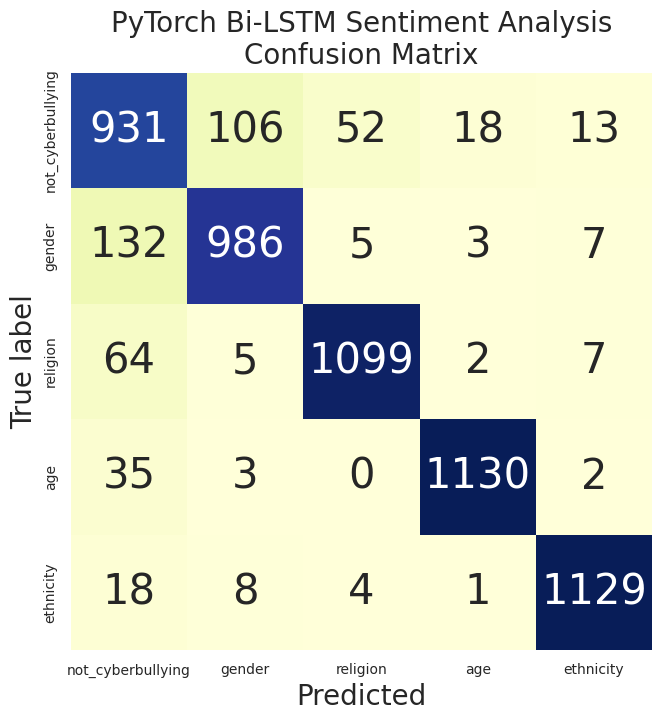

In [ ]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', idx2labels.keys())

In [ ]:
# BERT model
# first we load the pretrained bert tokenizer in transformer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X = df['cleaned_text'].values
y = [labels2idx[i] for i in df['labels']]

TRAIN_SIZE = 0.7
VALID_SIZE = 0.15
total_size = len(X)
train_size = int(TRAIN_SIZE * total_size)
valid_size = int(VALID_SIZE * total_size)
test_size = total_size - train_size - valid_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(train_size+valid_size), test_size=test_size, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=train_size, test_size=valid_size, stratify=y_train, random_state=seed_value)

In [ ]:
max_len = 128

def bert_tokenizer(data):
  input_ids = []
  attention_masks = []
  for sent in data:
    encoded_sent = tokenizer.encode_plus(
      text=sent,
      add_special_tokens=True,  # Add `[CLS]` and `[SEP]` special tokens
      max_length=max_len,  # Choose max length to truncate/pad
      padding='max_length',  # Pad sentence to max length
      return_attention_mask=True  # Return attention mask
      )
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))
  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)
  return input_ids, attention_masks

In [ ]:
train_inputs, train_masks = bert_tokenizer(X_train)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

In [ ]:
train_labels = torch.Tensor(y_train)
val_labels = torch.Tensor(y_valid)
test_labels = torch.Tensor(y_test)

In [ ]:
batch_size = 32

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
class Bert_Classifier(nn.Module):
  def __init__(self, freeze_bert=False):
    super(Bert_Classifier, self).__init__()
    # specify hidden dimension of BERT and the classifier, and number of labels
    n_input = 768
    n_hidden = 50
    n_output = 5
    # initialize BERT model
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    # define a simple classifier
    self.classifier = nn.Sequential(
        nn.Linear(n_input, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_output)
    )
    # freeze BERT parameters if specified
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    # extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
    last_hidden_state_cls = outputs[0][:, 0, :]
    # feed the extracted hidden state to the classifier to compute logits
    logits = self.classifier(last_hidden_state_cls)
    return logits

In [ ]:
bert_classifier = Bert_Classifier(freeze_bert=False).to(device)
epochs = 10
optimizer = optim.AdamW(bert_classifier.parameters(), lr=4e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()
# use the learning rate scheduler in transformers
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

In [47]:
early_stopping_patience = 10
early_stopping_counter = 0

max_valid_acc = 0

for e in range(epochs):

  # train model
  losses = []
  correct = 0
  total = 0
  bert_classifier.train()
  for inputs, masks, labels in train_dataloader:
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.type(torch.LongTensor).to(device)
    optimizer.zero_grad()
    output = bert_classifier(inputs, masks)
    loss = criterion(output, labels)
    losses.append(loss.item())
    loss.backward()

    # clip the norm of the gradients to 1.0 to prevent "exploding gradients"
    nn.utils.clip_grad_norm_(bert_classifier.parameters(), 1.0)
    optimizer.step()

    #get tensor of predicted values on the training set
    y_pred_train = torch.argmax(output, dim=1)

    correct += torch.sum(y_pred_train==labels).item()
    total += labels.size(0)

    #update learning rate
    lr_scheduler.step()
  avg_loss = np.mean(losses)
  acc = 100 * correct / total
  print(f'In epoch {e+1}, average traning loss is {avg_loss}, accuracy is {acc:.4f}%.')

  # validate model
  valid_losses = []
  valid_correct = 0
  valid_total = 0
  with torch.no_grad():

    bert_classifier.eval()
    for inputs, masks, labels in val_dataloader:
      inputs, masks, labels = inputs.to(device), masks.to(device), labels.type(torch.LongTensor).to(device)
      output = bert_classifier(inputs, masks)
      valid_loss = criterion(output, labels)
      valid_losses.append(valid_loss.item())
      y_pred_val = torch.argmax(output, dim=1)
      valid_correct += torch.sum(y_pred_val==labels).item()
      valid_total += labels.size(0)
    valid_avg_loss = np.mean(valid_losses)
    valid_acc = 100 * valid_correct / valid_total

    print(f'In epoch {e+1}, average validation loss is {valid_avg_loss}, accuracy is {valid_acc:.4f}%.')

  #Save model if validation accuracy increases
  if valid_acc >= max_valid_acc:
    torch.save(bert_classifier.state_dict(), data_path + 'bert_model/state_dict.pt')
    valid_acc_max = valid_acc
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  if early_stopping_counter > early_stopping_patience:
    print('Early stopped at epoch :', e+1)
    break

In epoch 1, average traning loss is 0.2781392453229582, accuracy is 91.2763%.
In epoch 1, average validation loss is 0.17973754943890885, accuracy is 93.9577%.
In epoch 2, average traning loss is 0.15503015373130594, accuracy is 94.8654%.
In epoch 2, average validation loss is 0.19791684462177148, accuracy is 93.9060%.
In epoch 3, average traning loss is 0.09625530479402272, accuracy is 97.0823%.
In epoch 3, average validation loss is 0.24187727256263555, accuracy is 93.8716%.
In epoch 4, average traning loss is 0.05909701289632687, accuracy is 98.4028%.
In epoch 4, average validation loss is 0.2947986549563491, accuracy is 93.3724%.
In epoch 5, average traning loss is 0.03545547244865239, accuracy is 99.1700%.
In epoch 5, average validation loss is 0.32594892038492956, accuracy is 93.4584%.
In epoch 6, average traning loss is 0.024917425891132706, accuracy is 99.3840%.
In epoch 6, average validation loss is 0.37762257139259886, accuracy is 93.4412%.
In epoch 7, average traning loss is

In [53]:
# Loading the best model
bert_classifier.load_state_dict(torch.load(data_path + 'bert_model/state_dict.pt'))

<All keys matched successfully>

In [54]:
def evaluate_model(model, test_loader):
  model.eval()
  y_pred_list = []
  y_test_list = []

  with torch.no_grad():
    for inputs, masks, labels in test_dataloader:
      inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
      output = model(inputs, masks)
      y_pred_test = torch.argmax(output, dim=1)
      y_pred_list.extend(y_pred_test.squeeze().tolist())
      y_test_list.extend(labels.squeeze().tolist())

  return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(bert_classifier, test_loader)

In [55]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=labels2idx.keys()))

Classification Report for Bi-LSTM :
                    precision    recall  f1-score   support

not_cyberbullying       0.83      0.87      0.85      1132
           gender       0.93      0.87      0.90      1141
         religion       0.94      0.97      0.95      1191
              age       0.99      0.96      0.98      1182
        ethnicity       0.98      0.99      0.98      1164

         accuracy                           0.93      5810
        macro avg       0.93      0.93      0.93      5810
     weighted avg       0.93      0.93      0.93      5810



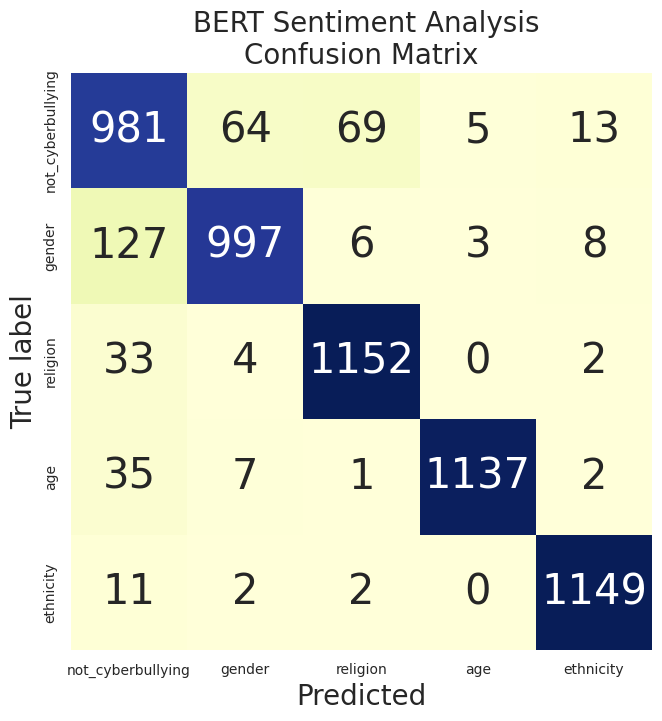

In [56]:
conf_matrix(y_test, y_pred_list,' BERT Sentiment Analysis\nConfusion Matrix', idx2labels.keys())